In [3]:
%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from config import Config
from datetime import datetime
from img_embedding import ImageEmbedding
from img_transformer import ImgTransformer
from img_util import show_img_tensor_CHW
from fliker_comment_tokenizer import FlikerCommentTokenizer
from fliker_img_comment_dataset import ImgCommentDataset
from model_util import count_parameters
from pathlib import Path
from text_token_embedding import TextTokenEmbedding
from text_casual_mask_transformer import TextMaskedTransformer
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm
from vlm_model import ImgLanguageModel
from vlm_train import train_model

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.profiler import profile, record_function, ProfilerActivity
from torch.utils.data import DataLoader
import torchvision.transforms.functional as VF



plt.rcParams["savefig.bbox"] = 'tight'

/opt/anaconda3/envs/torch/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
train_model()

Enriched img id: /tmp/enriched_results.csv
Enriched img id: /tmp/enriched_results.csv
Enriched img id: /tmp/enriched_results.csv
train_dataset:  114418
eval_dataset:  28605
test_dataset:  15892
train_dataloader:  5721
eval_data_loader:  1431
test_data_loader:  795
tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
batch_img_tensor: torch.Size([20, 3, 224, 224])
batch_img_id_tensor: torch.Size([20])
batch_comment_encoding: torch.Size([20, 50])
batch_text_mask: torch.Size([20, 50])
img_loss: 0.03713647648692131
text_loss: 0.011687690392136574
lm_loss: 12.123157501220703
pytorch_total_params: 291.7271 m
pytorch_total_trainable_params: 291.7271 m
+-----------------------------------------------------------------------------+------------+
|                                   Modules                                   | Parameters |
+-----------------------------------------------------------------------------+------------+
|      

STAGE:2024-09-09 10:21:35 42765:12381460 ActivityProfilerController.cpp:314] Completed Stage: Warm Up
[W CPUAllocator.cpp:235] Memory block of unknown size was allocated before the profiling started, profiler results will not include the deallocation event
STAGE:2024-09-09 10:21:42 42765:12381460 ActivityProfilerController.cpp:320] Completed Stage: Collection
STAGE:2024-09-09 10:21:42 42765:12381460 ActivityProfilerController.cpp:324] Completed Stage: Post Processing


tokens: 10000
tokenizer.is_fast: True


In [15]:
config = Config()

train_dataset = ImgCommentDataset(config, split="train")
eval_dataset = ImgCommentDataset(config, split="eval")
test_dataset = ImgCommentDataset(config, split="test")
print(f"train_dataset:  {len(train_dataset)}")
print(f"eval_dataset:  {len(eval_dataset)}")
print(f"test_dataset:  {len(test_dataset)}")


# Data Loader
BATCH_SIZE = 20
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"train_dataloader:  {len(train_dataloader)}")
print(f"eval_data_loader:  {len(eval_dataloader)}")
print(f"test_data_loader:  {len(test_dataloader)}")

Enriched img id: /tmp/enriched_results.csv
Enriched img id: /tmp/enriched_results.csv
Enriched img id: /tmp/enriched_results.csv
train_dataset:  114418
eval_dataset:  28605
test_dataset:  15892
train_dataloader:  5721
eval_data_loader:  1431
test_data_loader:  795


In [16]:
# train_dataset = ImgCommentDataset(config, split="train")

# BATCH_SIZE = 10
# train_data_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

batch_img_tensor, batch_img_id_tensor, batch_comment_encoding, batch_text_mask = next(
    iter(train_dataloader)
)
print(f"batch_img_tensor: {batch_img_tensor.size()}")
print(f"batch_img_id_tensor: {batch_img_id_tensor.size()}")
print(f"batch_comment_encoding: {batch_comment_encoding.size()}")
print(f"batch_text_mask: {batch_text_mask.size()}")

tokens: 10000
tokenizer.is_fast: True
batch_img_tensor: torch.Size([20, 3, 224, 224])
batch_img_id_tensor: torch.Size([20])
batch_comment_encoding: torch.Size([20, 50])
batch_text_mask: torch.Size([20, 50])


In [8]:
def evaluate_model_perf(model_file: str, split: str):
    config = Config
    device = torch.device("mps")

    # Loading Model
    target_model = ImgLanguageModel(config=config)
    target_model.load_state_dict(torch.load(model_file))
    target_model = target_model.to(device)
    target_model.eval()

    # Create Dataset and DataLoader
    BATCH_SIZE = 20
    target_dataset = ImgCommentDataset(config, split=split)
    target_dataloader = DataLoader(target_dataset, batch_size=BATCH_SIZE, shuffle=False)
    print(f"split:  {split}")
    print(f"target_dataset:  {len(target_dataset)}")
    print(f"target_dataloader:  {len(target_dataloader)}")

    img_losses = []
    text_losses = []
    lm_losses = []
    img_preds = []
    text_preds = []
    img_accuracies = []
    text_accuracies = []
    with torch.no_grad():
        for idx, data in tqdm(
            enumerate(target_dataloader), total=len(target_dataloader)
        ):
            (
                batch_img_tensor,
                batch_img_id_tensor,
                batch_text_tensor,
                batch_text_mask_tensor,
            ) = data
            batch_img_tensor = batch_img_tensor.to(device)
            batch_img_id_tensor = batch_img_id_tensor.to(device)
            batch_text_tensor = batch_text_tensor.to(device)
            batch_text_mask_tensor = batch_text_mask_tensor.to(device)
            (
                img_loss,
                text_loss,
                img_contrastive_prob,
                text_contrastive_prob,
                lm_loss,
                lm_logit,
            ) = target_model(
                batch_img_tensor=batch_img_tensor,
                batch_text_tensor=batch_text_tensor,
                batch_text_mask_tensor=batch_text_mask_tensor,
                batch_img_id_tensor=batch_img_id_tensor,
            )
            img_losses.append(img_loss.cpu())
            text_losses.append(text_loss.cpu())
            lm_losses.append(lm_loss.cpu())

            img_pred = torch.argmax(img_contrastive_prob, dim=1).cpu()
            img_preds.extend(img_pred)

            text_pred = torch.argmax(text_contrastive_prob, dim=1).cpu()
            text_preds.extend(text_pred)

            label_mask = torch.arange(img_pred.size()[0]).cpu()
            img_accuracy = img_pred == label_mask
            img_accuracies.extend(img_accuracy)

            text_accuracy = text_pred == label_mask
            text_accuracies.extend(text_accuracy)

            # if idx > 5:
            #     break

    img_losses = torch.tensor(img_losses)
    text_losses = torch.tensor(text_losses)
    lm_losses = torch.tensor(lm_losses)
    return (
        img_losses,
        text_losses,
        lm_losses,
        img_preds,
        text_preds,
        img_accuracies,
        text_accuracies,
    )


def viz_loss(title: str, img_losses, text_losses, lm_losses, bins=100):
    # fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
    df = pd.DataFrame(
        {
            "img_losses": np.array(img_losses),
            "text_losses": np.array(text_losses),
            "lm_losses": np.array(lm_losses),
        }
    )
    df.hist(bins=bins)
    # set title and axis labels
    plt.suptitle(title, x=0.5, y=1.05, ha="center", fontsize="small")
    # fig.text(0.5, 0.04, 'common X', ha='center')
    # fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')


def viz_predictions(title: str, img_preds, text_preds, bins=BATCH_SIZE):
    # fig, axes = plt.subplots(nrows=1, ncols=1, sharex=True, sharey=True)
    df = pd.DataFrame(
        {
            "img_preds": np.array(img_preds),
            "text_preds": np.array(text_preds),
        }
    )
    df.hist(bins=bins)
    # set title and axis labels
    plt.suptitle(title, x=0.5, y=1.05, ha="center", fontsize="small")
    # fig.text(0.5, 0.04, 'common X', ha='center')
    # fig.text(0.04, 0.5, 'common Y', va='center', rotation='vertical')

In [9]:
model_file = (
    "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_20240906_043641_final"
)
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
print(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
print(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
print(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
print(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
print(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True


RuntimeError: Error(s) in loading state_dict for ImgLanguageModel:
	Missing key(s) in state_dict: "img_transfomer.blocks.0.multihead_attention.attention_bias", "img_transfomer.blocks.1.multihead_attention.attention_bias", "img_transfomer.blocks.2.multihead_attention.attention_bias", "img_transfomer.blocks.3.multihead_attention.attention_bias", "img_transfomer.blocks.4.multihead_attention.attention_bias", "img_transfomer.blocks.5.multihead_attention.attention_bias", "img_transfomer.blocks.6.multihead_attention.attention_bias", "img_transfomer.blocks.6.multihead_attention.wq.weight", "img_transfomer.blocks.6.multihead_attention.wq.bias", "img_transfomer.blocks.6.multihead_attention.wk.weight", "img_transfomer.blocks.6.multihead_attention.wk.bias", "img_transfomer.blocks.6.multihead_attention.wv.weight", "img_transfomer.blocks.6.multihead_attention.wv.bias", "img_transfomer.blocks.6.multihead_attention.out_proj.weight", "img_transfomer.blocks.6.multihead_attention.out_proj.bias", "img_transfomer.blocks.6.norm1.weight", "img_transfomer.blocks.6.norm1.bias", "img_transfomer.blocks.6.norm2.weight", "img_transfomer.blocks.6.norm2.bias", "img_transfomer.blocks.6.linear1.weight", "img_transfomer.blocks.6.linear1.bias", "img_transfomer.blocks.6.linear2.weight", "img_transfomer.blocks.6.linear2.bias", "img_transfomer.blocks.6.mlp.0.weight", "img_transfomer.blocks.6.mlp.0.bias", "img_transfomer.blocks.6.mlp.2.weight", "img_transfomer.blocks.6.mlp.2.bias", "img_transfomer.blocks.7.multihead_attention.attention_bias", "img_transfomer.blocks.7.multihead_attention.wq.weight", "img_transfomer.blocks.7.multihead_attention.wq.bias", "img_transfomer.blocks.7.multihead_attention.wk.weight", "img_transfomer.blocks.7.multihead_attention.wk.bias", "img_transfomer.blocks.7.multihead_attention.wv.weight", "img_transfomer.blocks.7.multihead_attention.wv.bias", "img_transfomer.blocks.7.multihead_attention.out_proj.weight", "img_transfomer.blocks.7.multihead_attention.out_proj.bias", "img_transfomer.blocks.7.norm1.weight", "img_transfomer.blocks.7.norm1.bias", "img_transfomer.blocks.7.norm2.weight", "img_transfomer.blocks.7.norm2.bias", "img_transfomer.blocks.7.linear1.weight", "img_transfomer.blocks.7.linear1.bias", "img_transfomer.blocks.7.linear2.weight", "img_transfomer.blocks.7.linear2.bias", "img_transfomer.blocks.7.mlp.0.weight", "img_transfomer.blocks.7.mlp.0.bias", "img_transfomer.blocks.7.mlp.2.weight", "img_transfomer.blocks.7.mlp.2.bias", "img_transfomer.blocks.8.multihead_attention.attention_bias", "img_transfomer.blocks.8.multihead_attention.wq.weight", "img_transfomer.blocks.8.multihead_attention.wq.bias", "img_transfomer.blocks.8.multihead_attention.wk.weight", "img_transfomer.blocks.8.multihead_attention.wk.bias", "img_transfomer.blocks.8.multihead_attention.wv.weight", "img_transfomer.blocks.8.multihead_attention.wv.bias", "img_transfomer.blocks.8.multihead_attention.out_proj.weight", "img_transfomer.blocks.8.multihead_attention.out_proj.bias", "img_transfomer.blocks.8.norm1.weight", "img_transfomer.blocks.8.norm1.bias", "img_transfomer.blocks.8.norm2.weight", "img_transfomer.blocks.8.norm2.bias", "img_transfomer.blocks.8.linear1.weight", "img_transfomer.blocks.8.linear1.bias", "img_transfomer.blocks.8.linear2.weight", "img_transfomer.blocks.8.linear2.bias", "img_transfomer.blocks.8.mlp.0.weight", "img_transfomer.blocks.8.mlp.0.bias", "img_transfomer.blocks.8.mlp.2.weight", "img_transfomer.blocks.8.mlp.2.bias", "img_transfomer.blocks.9.multihead_attention.attention_bias", "img_transfomer.blocks.9.multihead_attention.wq.weight", "img_transfomer.blocks.9.multihead_attention.wq.bias", "img_transfomer.blocks.9.multihead_attention.wk.weight", "img_transfomer.blocks.9.multihead_attention.wk.bias", "img_transfomer.blocks.9.multihead_attention.wv.weight", "img_transfomer.blocks.9.multihead_attention.wv.bias", "img_transfomer.blocks.9.multihead_attention.out_proj.weight", "img_transfomer.blocks.9.multihead_attention.out_proj.bias", "img_transfomer.blocks.9.norm1.weight", "img_transfomer.blocks.9.norm1.bias", "img_transfomer.blocks.9.norm2.weight", "img_transfomer.blocks.9.norm2.bias", "img_transfomer.blocks.9.linear1.weight", "img_transfomer.blocks.9.linear1.bias", "img_transfomer.blocks.9.linear2.weight", "img_transfomer.blocks.9.linear2.bias", "img_transfomer.blocks.9.mlp.0.weight", "img_transfomer.blocks.9.mlp.0.bias", "img_transfomer.blocks.9.mlp.2.weight", "img_transfomer.blocks.9.mlp.2.bias", "img_transfomer.blocks.10.multihead_attention.attention_bias", "img_transfomer.blocks.10.multihead_attention.wq.weight", "img_transfomer.blocks.10.multihead_attention.wq.bias", "img_transfomer.blocks.10.multihead_attention.wk.weight", "img_transfomer.blocks.10.multihead_attention.wk.bias", "img_transfomer.blocks.10.multihead_attention.wv.weight", "img_transfomer.blocks.10.multihead_attention.wv.bias", "img_transfomer.blocks.10.multihead_attention.out_proj.weight", "img_transfomer.blocks.10.multihead_attention.out_proj.bias", "img_transfomer.blocks.10.norm1.weight", "img_transfomer.blocks.10.norm1.bias", "img_transfomer.blocks.10.norm2.weight", "img_transfomer.blocks.10.norm2.bias", "img_transfomer.blocks.10.linear1.weight", "img_transfomer.blocks.10.linear1.bias", "img_transfomer.blocks.10.linear2.weight", "img_transfomer.blocks.10.linear2.bias", "img_transfomer.blocks.10.mlp.0.weight", "img_transfomer.blocks.10.mlp.0.bias", "img_transfomer.blocks.10.mlp.2.weight", "img_transfomer.blocks.10.mlp.2.bias", "img_transfomer.blocks.11.multihead_attention.attention_bias", "img_transfomer.blocks.11.multihead_attention.wq.weight", "img_transfomer.blocks.11.multihead_attention.wq.bias", "img_transfomer.blocks.11.multihead_attention.wk.weight", "img_transfomer.blocks.11.multihead_attention.wk.bias", "img_transfomer.blocks.11.multihead_attention.wv.weight", "img_transfomer.blocks.11.multihead_attention.wv.bias", "img_transfomer.blocks.11.multihead_attention.out_proj.weight", "img_transfomer.blocks.11.multihead_attention.out_proj.bias", "img_transfomer.blocks.11.norm1.weight", "img_transfomer.blocks.11.norm1.bias", "img_transfomer.blocks.11.norm2.weight", "img_transfomer.blocks.11.norm2.bias", "img_transfomer.blocks.11.linear1.weight", "img_transfomer.blocks.11.linear1.bias", "img_transfomer.blocks.11.linear2.weight", "img_transfomer.blocks.11.linear2.bias", "img_transfomer.blocks.11.mlp.0.weight", "img_transfomer.blocks.11.mlp.0.bias", "img_transfomer.blocks.11.mlp.2.weight", "img_transfomer.blocks.11.mlp.2.bias", "img_transfomer.blocks.12.multihead_attention.attention_bias", "img_transfomer.blocks.12.multihead_attention.wq.weight", "img_transfomer.blocks.12.multihead_attention.wq.bias", "img_transfomer.blocks.12.multihead_attention.wk.weight", "img_transfomer.blocks.12.multihead_attention.wk.bias", "img_transfomer.blocks.12.multihead_attention.wv.weight", "img_transfomer.blocks.12.multihead_attention.wv.bias", "img_transfomer.blocks.12.multihead_attention.out_proj.weight", "img_transfomer.blocks.12.multihead_attention.out_proj.bias", "img_transfomer.blocks.12.norm1.weight", "img_transfomer.blocks.12.norm1.bias", "img_transfomer.blocks.12.norm2.weight", "img_transfomer.blocks.12.norm2.bias", "img_transfomer.blocks.12.linear1.weight", "img_transfomer.blocks.12.linear1.bias", "img_transfomer.blocks.12.linear2.weight", "img_transfomer.blocks.12.linear2.bias", "img_transfomer.blocks.12.mlp.0.weight", "img_transfomer.blocks.12.mlp.0.bias", "img_transfomer.blocks.12.mlp.2.weight", "img_transfomer.blocks.12.mlp.2.bias", "img_transfomer.blocks.13.multihead_attention.attention_bias", "img_transfomer.blocks.13.multihead_attention.wq.weight", "img_transfomer.blocks.13.multihead_attention.wq.bias", "img_transfomer.blocks.13.multihead_attention.wk.weight", "img_transfomer.blocks.13.multihead_attention.wk.bias", "img_transfomer.blocks.13.multihead_attention.wv.weight", "img_transfomer.blocks.13.multihead_attention.wv.bias", "img_transfomer.blocks.13.multihead_attention.out_proj.weight", "img_transfomer.blocks.13.multihead_attention.out_proj.bias", "img_transfomer.blocks.13.norm1.weight", "img_transfomer.blocks.13.norm1.bias", "img_transfomer.blocks.13.norm2.weight", "img_transfomer.blocks.13.norm2.bias", "img_transfomer.blocks.13.linear1.weight", "img_transfomer.blocks.13.linear1.bias", "img_transfomer.blocks.13.linear2.weight", "img_transfomer.blocks.13.linear2.bias", "img_transfomer.blocks.13.mlp.0.weight", "img_transfomer.blocks.13.mlp.0.bias", "img_transfomer.blocks.13.mlp.2.weight", "img_transfomer.blocks.13.mlp.2.bias", "text_transformer.blocks.6.multihead_attention.wq.weight", "text_transformer.blocks.6.multihead_attention.wq.bias", "text_transformer.blocks.6.multihead_attention.wk.weight", "text_transformer.blocks.6.multihead_attention.wk.bias", "text_transformer.blocks.6.multihead_attention.wv.weight", "text_transformer.blocks.6.multihead_attention.wv.bias", "text_transformer.blocks.6.multihead_attention.out_proj.weight", "text_transformer.blocks.6.multihead_attention.out_proj.bias", "text_transformer.blocks.6.norm1.weight", "text_transformer.blocks.6.norm1.bias", "text_transformer.blocks.6.norm2.weight", "text_transformer.blocks.6.norm2.bias", "text_transformer.blocks.6.linear1.weight", "text_transformer.blocks.6.linear1.bias", "text_transformer.blocks.6.linear2.weight", "text_transformer.blocks.6.linear2.bias", "text_transformer.blocks.6.mlp.0.weight", "text_transformer.blocks.6.mlp.0.bias", "text_transformer.blocks.6.mlp.2.weight", "text_transformer.blocks.6.mlp.2.bias", "text_transformer.blocks.7.multihead_attention.wq.weight", "text_transformer.blocks.7.multihead_attention.wq.bias", "text_transformer.blocks.7.multihead_attention.wk.weight", "text_transformer.blocks.7.multihead_attention.wk.bias", "text_transformer.blocks.7.multihead_attention.wv.weight", "text_transformer.blocks.7.multihead_attention.wv.bias", "text_transformer.blocks.7.multihead_attention.out_proj.weight", "text_transformer.blocks.7.multihead_attention.out_proj.bias", "text_transformer.blocks.7.norm1.weight", "text_transformer.blocks.7.norm1.bias", "text_transformer.blocks.7.norm2.weight", "text_transformer.blocks.7.norm2.bias", "text_transformer.blocks.7.linear1.weight", "text_transformer.blocks.7.linear1.bias", "text_transformer.blocks.7.linear2.weight", "text_transformer.blocks.7.linear2.bias", "text_transformer.blocks.7.mlp.0.weight", "text_transformer.blocks.7.mlp.0.bias", "text_transformer.blocks.7.mlp.2.weight", "text_transformer.blocks.7.mlp.2.bias", "text_transformer.blocks.8.multihead_attention.wq.weight", "text_transformer.blocks.8.multihead_attention.wq.bias", "text_transformer.blocks.8.multihead_attention.wk.weight", "text_transformer.blocks.8.multihead_attention.wk.bias", "text_transformer.blocks.8.multihead_attention.wv.weight", "text_transformer.blocks.8.multihead_attention.wv.bias", "text_transformer.blocks.8.multihead_attention.out_proj.weight", "text_transformer.blocks.8.multihead_attention.out_proj.bias", "text_transformer.blocks.8.norm1.weight", "text_transformer.blocks.8.norm1.bias", "text_transformer.blocks.8.norm2.weight", "text_transformer.blocks.8.norm2.bias", "text_transformer.blocks.8.linear1.weight", "text_transformer.blocks.8.linear1.bias", "text_transformer.blocks.8.linear2.weight", "text_transformer.blocks.8.linear2.bias", "text_transformer.blocks.8.mlp.0.weight", "text_transformer.blocks.8.mlp.0.bias", "text_transformer.blocks.8.mlp.2.weight", "text_transformer.blocks.8.mlp.2.bias", "text_transformer.blocks.9.multihead_attention.wq.weight", "text_transformer.blocks.9.multihead_attention.wq.bias", "text_transformer.blocks.9.multihead_attention.wk.weight", "text_transformer.blocks.9.multihead_attention.wk.bias", "text_transformer.blocks.9.multihead_attention.wv.weight", "text_transformer.blocks.9.multihead_attention.wv.bias", "text_transformer.blocks.9.multihead_attention.out_proj.weight", "text_transformer.blocks.9.multihead_attention.out_proj.bias", "text_transformer.blocks.9.norm1.weight", "text_transformer.blocks.9.norm1.bias", "text_transformer.blocks.9.norm2.weight", "text_transformer.blocks.9.norm2.bias", "text_transformer.blocks.9.linear1.weight", "text_transformer.blocks.9.linear1.bias", "text_transformer.blocks.9.linear2.weight", "text_transformer.blocks.9.linear2.bias", "text_transformer.blocks.9.mlp.0.weight", "text_transformer.blocks.9.mlp.0.bias", "text_transformer.blocks.9.mlp.2.weight", "text_transformer.blocks.9.mlp.2.bias", "text_transformer.blocks.10.multihead_attention.wq.weight", "text_transformer.blocks.10.multihead_attention.wq.bias", "text_transformer.blocks.10.multihead_attention.wk.weight", "text_transformer.blocks.10.multihead_attention.wk.bias", "text_transformer.blocks.10.multihead_attention.wv.weight", "text_transformer.blocks.10.multihead_attention.wv.bias", "text_transformer.blocks.10.multihead_attention.out_proj.weight", "text_transformer.blocks.10.multihead_attention.out_proj.bias", "text_transformer.blocks.10.norm1.weight", "text_transformer.blocks.10.norm1.bias", "text_transformer.blocks.10.norm2.weight", "text_transformer.blocks.10.norm2.bias", "text_transformer.blocks.10.linear1.weight", "text_transformer.blocks.10.linear1.bias", "text_transformer.blocks.10.linear2.weight", "text_transformer.blocks.10.linear2.bias", "text_transformer.blocks.10.mlp.0.weight", "text_transformer.blocks.10.mlp.0.bias", "text_transformer.blocks.10.mlp.2.weight", "text_transformer.blocks.10.mlp.2.bias", "text_transformer.blocks.11.multihead_attention.wq.weight", "text_transformer.blocks.11.multihead_attention.wq.bias", "text_transformer.blocks.11.multihead_attention.wk.weight", "text_transformer.blocks.11.multihead_attention.wk.bias", "text_transformer.blocks.11.multihead_attention.wv.weight", "text_transformer.blocks.11.multihead_attention.wv.bias", "text_transformer.blocks.11.multihead_attention.out_proj.weight", "text_transformer.blocks.11.multihead_attention.out_proj.bias", "text_transformer.blocks.11.norm1.weight", "text_transformer.blocks.11.norm1.bias", "text_transformer.blocks.11.norm2.weight", "text_transformer.blocks.11.norm2.bias", "text_transformer.blocks.11.linear1.weight", "text_transformer.blocks.11.linear1.bias", "text_transformer.blocks.11.linear2.weight", "text_transformer.blocks.11.linear2.bias", "text_transformer.blocks.11.mlp.0.weight", "text_transformer.blocks.11.mlp.0.bias", "text_transformer.blocks.11.mlp.2.weight", "text_transformer.blocks.11.mlp.2.bias", "text_transformer.blocks.12.multihead_attention.wq.weight", "text_transformer.blocks.12.multihead_attention.wq.bias", "text_transformer.blocks.12.multihead_attention.wk.weight", "text_transformer.blocks.12.multihead_attention.wk.bias", "text_transformer.blocks.12.multihead_attention.wv.weight", "text_transformer.blocks.12.multihead_attention.wv.bias", "text_transformer.blocks.12.multihead_attention.out_proj.weight", "text_transformer.blocks.12.multihead_attention.out_proj.bias", "text_transformer.blocks.12.norm1.weight", "text_transformer.blocks.12.norm1.bias", "text_transformer.blocks.12.norm2.weight", "text_transformer.blocks.12.norm2.bias", "text_transformer.blocks.12.linear1.weight", "text_transformer.blocks.12.linear1.bias", "text_transformer.blocks.12.linear2.weight", "text_transformer.blocks.12.linear2.bias", "text_transformer.blocks.12.mlp.0.weight", "text_transformer.blocks.12.mlp.0.bias", "text_transformer.blocks.12.mlp.2.weight", "text_transformer.blocks.12.mlp.2.bias", "text_transformer.blocks.13.multihead_attention.wq.weight", "text_transformer.blocks.13.multihead_attention.wq.bias", "text_transformer.blocks.13.multihead_attention.wk.weight", "text_transformer.blocks.13.multihead_attention.wk.bias", "text_transformer.blocks.13.multihead_attention.wv.weight", "text_transformer.blocks.13.multihead_attention.wv.bias", "text_transformer.blocks.13.multihead_attention.out_proj.weight", "text_transformer.blocks.13.multihead_attention.out_proj.bias", "text_transformer.blocks.13.norm1.weight", "text_transformer.blocks.13.norm1.bias", "text_transformer.blocks.13.norm2.weight", "text_transformer.blocks.13.norm2.bias", "text_transformer.blocks.13.linear1.weight", "text_transformer.blocks.13.linear1.bias", "text_transformer.blocks.13.linear2.weight", "text_transformer.blocks.13.linear2.bias", "text_transformer.blocks.13.mlp.0.weight", "text_transformer.blocks.13.mlp.0.bias", "text_transformer.blocks.13.mlp.2.weight", "text_transformer.blocks.13.mlp.2.bias", "img_caption_model.transformer.blocks.6.multihead_attention.wq.weight", "img_caption_model.transformer.blocks.6.multihead_attention.wq.bias", "img_caption_model.transformer.blocks.6.multihead_attention.wk.weight", "img_caption_model.transformer.blocks.6.multihead_attention.wk.bias", "img_caption_model.transformer.blocks.6.multihead_attention.wv.weight", "img_caption_model.transformer.blocks.6.multihead_attention.wv.bias", "img_caption_model.transformer.blocks.6.multihead_attention.out_proj.weight", "img_caption_model.transformer.blocks.6.multihead_attention.out_proj.bias", "img_caption_model.transformer.blocks.6.norm1.weight", "img_caption_model.transformer.blocks.6.norm1.bias", "img_caption_model.transformer.blocks.6.norm2.weight", "img_caption_model.transformer.blocks.6.norm2.bias", "img_caption_model.transformer.blocks.6.linear1.weight", "img_caption_model.transformer.blocks.6.linear1.bias", "img_caption_model.transformer.blocks.6.linear2.weight", "img_caption_model.transformer.blocks.6.linear2.bias", "img_caption_model.transformer.blocks.6.mlp.0.weight", "img_caption_model.transformer.blocks.6.mlp.0.bias", "img_caption_model.transformer.blocks.6.mlp.2.weight", "img_caption_model.transformer.blocks.6.mlp.2.bias", "img_caption_model.transformer.blocks.7.multihead_attention.wq.weight", "img_caption_model.transformer.blocks.7.multihead_attention.wq.bias", "img_caption_model.transformer.blocks.7.multihead_attention.wk.weight", "img_caption_model.transformer.blocks.7.multihead_attention.wk.bias", "img_caption_model.transformer.blocks.7.multihead_attention.wv.weight", "img_caption_model.transformer.blocks.7.multihead_attention.wv.bias", "img_caption_model.transformer.blocks.7.multihead_attention.out_proj.weight", "img_caption_model.transformer.blocks.7.multihead_attention.out_proj.bias", "img_caption_model.transformer.blocks.7.norm1.weight", "img_caption_model.transformer.blocks.7.norm1.bias", "img_caption_model.transformer.blocks.7.norm2.weight", "img_caption_model.transformer.blocks.7.norm2.bias", "img_caption_model.transformer.blocks.7.linear1.weight", "img_caption_model.transformer.blocks.7.linear1.bias", "img_caption_model.transformer.blocks.7.linear2.weight", "img_caption_model.transformer.blocks.7.linear2.bias", "img_caption_model.transformer.blocks.7.mlp.0.weight", "img_caption_model.transformer.blocks.7.mlp.0.bias", "img_caption_model.transformer.blocks.7.mlp.2.weight", "img_caption_model.transformer.blocks.7.mlp.2.bias", "img_caption_model.transformer.blocks.8.multihead_attention.wq.weight", "img_caption_model.transformer.blocks.8.multihead_attention.wq.bias", "img_caption_model.transformer.blocks.8.multihead_attention.wk.weight", "img_caption_model.transformer.blocks.8.multihead_attention.wk.bias", "img_caption_model.transformer.blocks.8.multihead_attention.wv.weight", "img_caption_model.transformer.blocks.8.multihead_attention.wv.bias", "img_caption_model.transformer.blocks.8.multihead_attention.out_proj.weight", "img_caption_model.transformer.blocks.8.multihead_attention.out_proj.bias", "img_caption_model.transformer.blocks.8.norm1.weight", "img_caption_model.transformer.blocks.8.norm1.bias", "img_caption_model.transformer.blocks.8.norm2.weight", "img_caption_model.transformer.blocks.8.norm2.bias", "img_caption_model.transformer.blocks.8.linear1.weight", "img_caption_model.transformer.blocks.8.linear1.bias", "img_caption_model.transformer.blocks.8.linear2.weight", "img_caption_model.transformer.blocks.8.linear2.bias", "img_caption_model.transformer.blocks.8.mlp.0.weight", "img_caption_model.transformer.blocks.8.mlp.0.bias", "img_caption_model.transformer.blocks.8.mlp.2.weight", "img_caption_model.transformer.blocks.8.mlp.2.bias", "img_caption_model.transformer.blocks.9.multihead_attention.wq.weight", "img_caption_model.transformer.blocks.9.multihead_attention.wq.bias", "img_caption_model.transformer.blocks.9.multihead_attention.wk.weight", "img_caption_model.transformer.blocks.9.multihead_attention.wk.bias", "img_caption_model.transformer.blocks.9.multihead_attention.wv.weight", "img_caption_model.transformer.blocks.9.multihead_attention.wv.bias", "img_caption_model.transformer.blocks.9.multihead_attention.out_proj.weight", "img_caption_model.transformer.blocks.9.multihead_attention.out_proj.bias", "img_caption_model.transformer.blocks.9.norm1.weight", "img_caption_model.transformer.blocks.9.norm1.bias", "img_caption_model.transformer.blocks.9.norm2.weight", "img_caption_model.transformer.blocks.9.norm2.bias", "img_caption_model.transformer.blocks.9.linear1.weight", "img_caption_model.transformer.blocks.9.linear1.bias", "img_caption_model.transformer.blocks.9.linear2.weight", "img_caption_model.transformer.blocks.9.linear2.bias", "img_caption_model.transformer.blocks.9.mlp.0.weight", "img_caption_model.transformer.blocks.9.mlp.0.bias", "img_caption_model.transformer.blocks.9.mlp.2.weight", "img_caption_model.transformer.blocks.9.mlp.2.bias", "img_caption_model.transformer.blocks.10.multihead_attention.wq.weight", "img_caption_model.transformer.blocks.10.multihead_attention.wq.bias", "img_caption_model.transformer.blocks.10.multihead_attention.wk.weight", "img_caption_model.transformer.blocks.10.multihead_attention.wk.bias", "img_caption_model.transformer.blocks.10.multihead_attention.wv.weight", "img_caption_model.transformer.blocks.10.multihead_attention.wv.bias", "img_caption_model.transformer.blocks.10.multihead_attention.out_proj.weight", "img_caption_model.transformer.blocks.10.multihead_attention.out_proj.bias", "img_caption_model.transformer.blocks.10.norm1.weight", "img_caption_model.transformer.blocks.10.norm1.bias", "img_caption_model.transformer.blocks.10.norm2.weight", "img_caption_model.transformer.blocks.10.norm2.bias", "img_caption_model.transformer.blocks.10.linear1.weight", "img_caption_model.transformer.blocks.10.linear1.bias", "img_caption_model.transformer.blocks.10.linear2.weight", "img_caption_model.transformer.blocks.10.linear2.bias", "img_caption_model.transformer.blocks.10.mlp.0.weight", "img_caption_model.transformer.blocks.10.mlp.0.bias", "img_caption_model.transformer.blocks.10.mlp.2.weight", "img_caption_model.transformer.blocks.10.mlp.2.bias", "img_caption_model.transformer.blocks.11.multihead_attention.wq.weight", "img_caption_model.transformer.blocks.11.multihead_attention.wq.bias", "img_caption_model.transformer.blocks.11.multihead_attention.wk.weight", "img_caption_model.transformer.blocks.11.multihead_attention.wk.bias", "img_caption_model.transformer.blocks.11.multihead_attention.wv.weight", "img_caption_model.transformer.blocks.11.multihead_attention.wv.bias", "img_caption_model.transformer.blocks.11.multihead_attention.out_proj.weight", "img_caption_model.transformer.blocks.11.multihead_attention.out_proj.bias", "img_caption_model.transformer.blocks.11.norm1.weight", "img_caption_model.transformer.blocks.11.norm1.bias", "img_caption_model.transformer.blocks.11.norm2.weight", "img_caption_model.transformer.blocks.11.norm2.bias", "img_caption_model.transformer.blocks.11.linear1.weight", "img_caption_model.transformer.blocks.11.linear1.bias", "img_caption_model.transformer.blocks.11.linear2.weight", "img_caption_model.transformer.blocks.11.linear2.bias", "img_caption_model.transformer.blocks.11.mlp.0.weight", "img_caption_model.transformer.blocks.11.mlp.0.bias", "img_caption_model.transformer.blocks.11.mlp.2.weight", "img_caption_model.transformer.blocks.11.mlp.2.bias", "img_caption_model.transformer.blocks.12.multihead_attention.wq.weight", "img_caption_model.transformer.blocks.12.multihead_attention.wq.bias", "img_caption_model.transformer.blocks.12.multihead_attention.wk.weight", "img_caption_model.transformer.blocks.12.multihead_attention.wk.bias", "img_caption_model.transformer.blocks.12.multihead_attention.wv.weight", "img_caption_model.transformer.blocks.12.multihead_attention.wv.bias", "img_caption_model.transformer.blocks.12.multihead_attention.out_proj.weight", "img_caption_model.transformer.blocks.12.multihead_attention.out_proj.bias", "img_caption_model.transformer.blocks.12.norm1.weight", "img_caption_model.transformer.blocks.12.norm1.bias", "img_caption_model.transformer.blocks.12.norm2.weight", "img_caption_model.transformer.blocks.12.norm2.bias", "img_caption_model.transformer.blocks.12.linear1.weight", "img_caption_model.transformer.blocks.12.linear1.bias", "img_caption_model.transformer.blocks.12.linear2.weight", "img_caption_model.transformer.blocks.12.linear2.bias", "img_caption_model.transformer.blocks.12.mlp.0.weight", "img_caption_model.transformer.blocks.12.mlp.0.bias", "img_caption_model.transformer.blocks.12.mlp.2.weight", "img_caption_model.transformer.blocks.12.mlp.2.bias", "img_caption_model.transformer.blocks.13.multihead_attention.wq.weight", "img_caption_model.transformer.blocks.13.multihead_attention.wq.bias", "img_caption_model.transformer.blocks.13.multihead_attention.wk.weight", "img_caption_model.transformer.blocks.13.multihead_attention.wk.bias", "img_caption_model.transformer.blocks.13.multihead_attention.wv.weight", "img_caption_model.transformer.blocks.13.multihead_attention.wv.bias", "img_caption_model.transformer.blocks.13.multihead_attention.out_proj.weight", "img_caption_model.transformer.blocks.13.multihead_attention.out_proj.bias", "img_caption_model.transformer.blocks.13.norm1.weight", "img_caption_model.transformer.blocks.13.norm1.bias", "img_caption_model.transformer.blocks.13.norm2.weight", "img_caption_model.transformer.blocks.13.norm2.bias", "img_caption_model.transformer.blocks.13.linear1.weight", "img_caption_model.transformer.blocks.13.linear1.bias", "img_caption_model.transformer.blocks.13.linear2.weight", "img_caption_model.transformer.blocks.13.linear2.bias", "img_caption_model.transformer.blocks.13.mlp.0.weight", "img_caption_model.transformer.blocks.13.mlp.0.bias", "img_caption_model.transformer.blocks.13.mlp.2.weight", "img_caption_model.transformer.blocks.13.mlp.2.bias". 
	size mismatch for img_proj.weight: copying a param with shape torch.Size([1024, 728]) from checkpoint, the shape in current model is torch.Size([728, 728]).
	size mismatch for img_proj.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([728]).
	size mismatch for text_proj.weight: copying a param with shape torch.Size([1024, 728]) from checkpoint, the shape in current model is torch.Size([728, 728]).
	size mismatch for text_proj.bias: copying a param with shape torch.Size([1024]) from checkpoint, the shape in current model is torch.Size([728]).

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
split:  test
target_dataset:  15892
target_dataloader:  795


  0%|          | 0/795 [00:00<?, ?it/s]

tokens: 10000
tokenizer.is_fast: True


100%|██████████| 795/795 [03:56<00:00,  3.37it/s]


img_losses: mean-2.926727294921875, std-0.2024785429239273
text_losses: mean-2.890638828277588, std-0.20288899540901184
lm_losses: mean-0.021333353593945503, std-0.062381356954574585
img accuracy: 0.08771709352731705
text accuracy: 0.07620186358690262


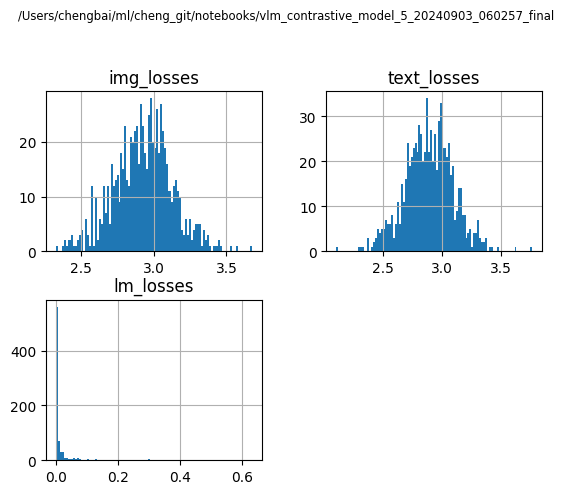

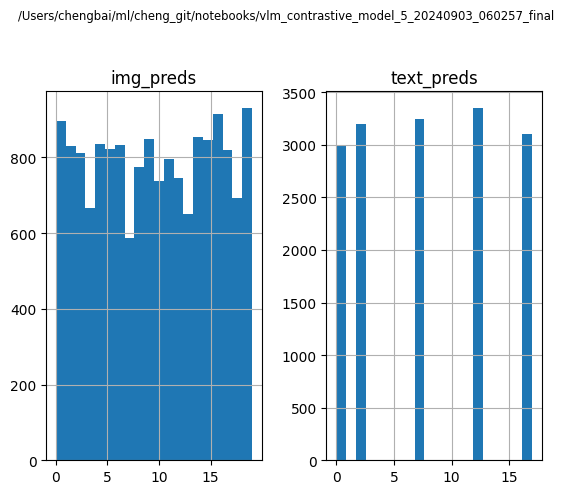

In [ ]:
model_file = "/Users/chengbai/ml/cheng_git/notebooks/vlm_contrastive_model_5_20240903_060257_final"
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
print(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
print(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
print(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
print(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
print(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
split:  test
target_dataset:  15892
target_dataloader:  795


  0%|          | 0/795 [00:00<?, ?it/s]

tokens: 10000
tokenizer.is_fast: True


100%|██████████| 795/795 [04:01<00:00,  3.29it/s]


img_losses: mean-2.9592390060424805, std-0.09932839125394821
text_losses: mean-2.9480690956115723, std-0.09810122847557068
lm_losses: mean-0.79759281873703, std-0.16128289699554443
img accuracy: 0.06984646618366241
text accuracy: 0.060281902551651


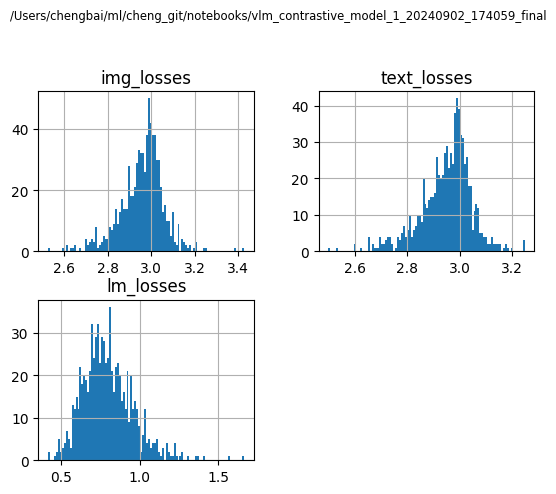

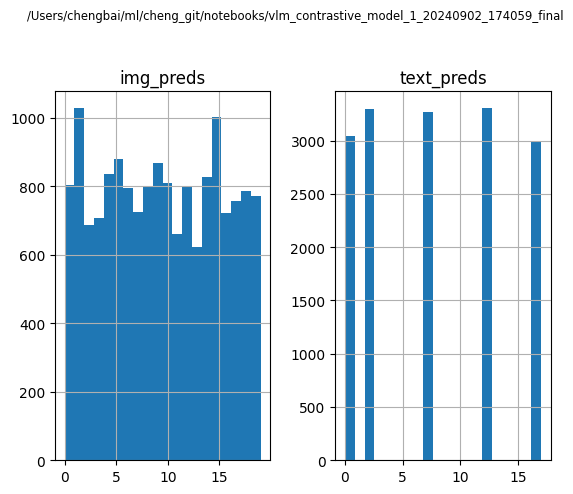

In [ ]:
model_file = "/Users/chengbai/ml/cheng_git/notebooks/vlm_contrastive_model_1_20240902_174059_final"
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
print(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
print(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
print(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
print(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
print(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

In [10]:
model_file = "/Users/chengbai/ml/cheng_git/notebooks/vlm_contrastive_model_5_20240901_234713_final"
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
print(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
print(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
print(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
print(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
print(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True


RuntimeError: Error(s) in loading state_dict for ImgLanguageModel:
	Missing key(s) in state_dict: "img_norm.weight", "img_norm.bias", "text_norm.weight", "text_norm.bias". 
	size mismatch for img_proj.weight: copying a param with shape torch.Size([1024, 142688]) from checkpoint, the shape in current model is torch.Size([1024, 728]).
	size mismatch for text_proj.weight: copying a param with shape torch.Size([1024, 36400]) from checkpoint, the shape in current model is torch.Size([1024, 728]).

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
tokens: 10000
tokenizer.is_fast: True
split:  test
target_dataset:  15892
target_dataloader:  795


100%|██████████| 795/795 [04:14<00:00,  3.13it/s]


img_losses: mean-10.27953052520752, std-2.624840021133423
text_losses: mean-2.229250431060791, std-0.5986806750297546
lm_losses: mean-0.0012080925516784191, std-0.004216477274894714
img accuracy: 0.050969041883945465
text accuracy: 0.051157813519239426


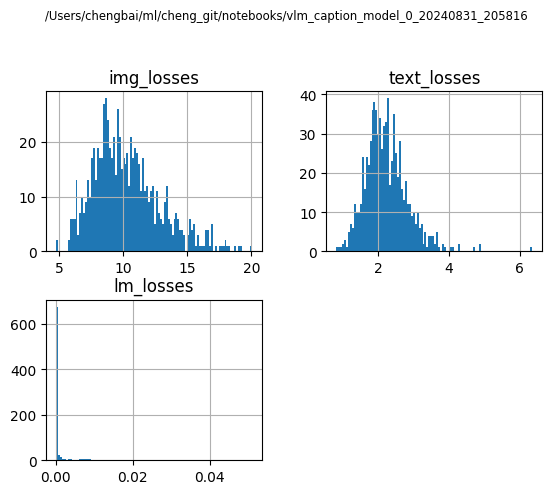

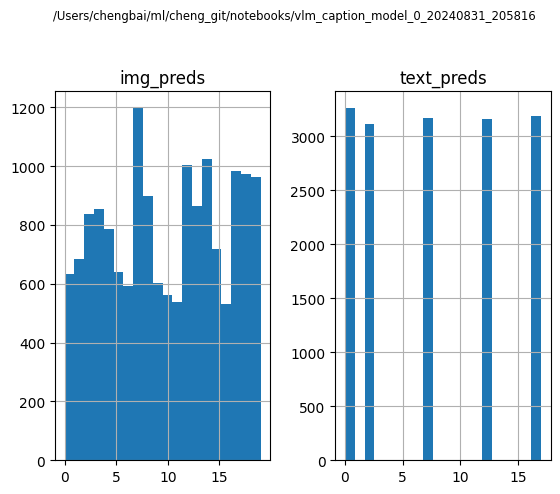

In [ ]:
model_file = (
    "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_0_20240831_205816"
)
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
print(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
print(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
print(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
print(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
print(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True
Enriched img id: /tmp/enriched_results.csv
tokens: 10000
tokenizer.is_fast: True
split:  test
target_dataset:  15892
target_dataloader:  795


100%|██████████| 795/795 [04:09<00:00,  3.19it/s]


img_losses: mean-0.5474981665611267, std-0.2033354938030243
text_losses: mean-0.3965409994125366, std-0.09175096452236176
lm_losses: mean-0.0007577572832815349, std-0.004581856075674295
img accuracy: 0.05336018279194832
text accuracy: 0.050843190401792526


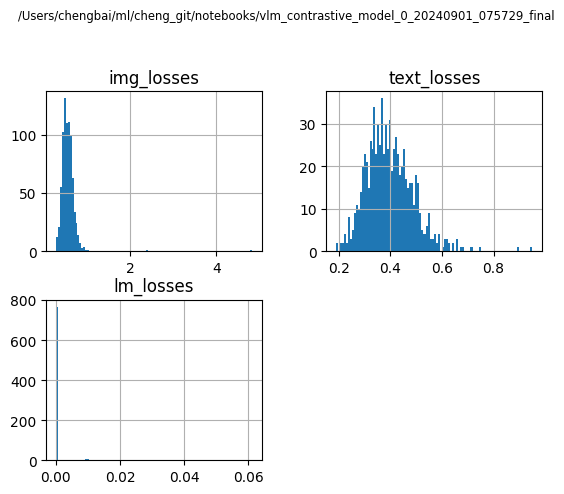

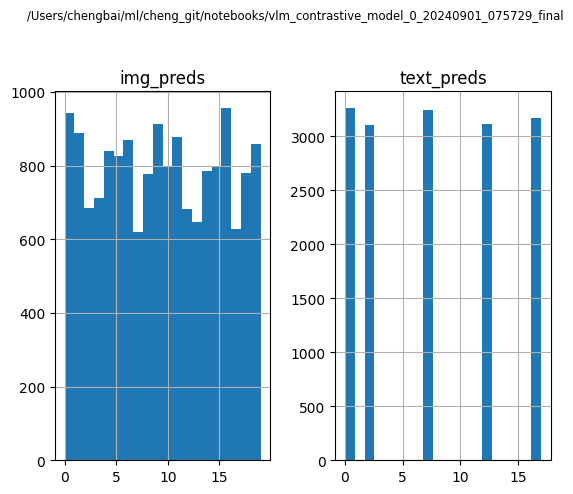

In [14]:
model_file = "/Users/chengbai/ml/cheng_git/notebooks/vlm_contrastive_model_0_20240901_075729_final"
(
    img_losses,
    text_losses,
    lm_losses,
    img_preds,
    text_preds,
    img_accuracies,
    text_accuracies,
) = evaluate_model_perf(model_file=model_file, split="test")
print(f"img_losses: mean-{img_losses.mean()}, std-{img_losses.std()}")
print(f"text_losses: mean-{text_losses.mean()}, std-{text_losses.std()}")
print(f"lm_losses: mean-{lm_losses.mean()}, std-{lm_losses.std()}")
print(f"img accuracy: {sum(img_accuracies)/len(img_accuracies)}")
print(f"text accuracy: {sum(text_accuracies)/len(text_accuracies)}")

viz_loss(model_file, img_losses, text_losses, lm_losses)
viz_predictions(model_file, img_preds, text_preds)

In [12]:
device = torch.device("mps")
model_path = (
    "/Users/chengbai/ml/cheng_git/notebooks/vlm_caption_model_20240905_023757_final"
)
model_trained = ImgLanguageModel(config=config)
model_trained.load_state_dict(torch.load(model_path))
model_trained = model_trained.to(device)
model_trained.eval()

tokens: 10000
tokenizer.is_fast: True
tokens: 10000
tokenizer.is_fast: True


ImgLanguageModel(
  (img_embedding): ImageEmbedding(
    (conv): Conv2d(3, 728, kernel_size=(16, 16), stride=(16, 16), padding=valid)
    (pos_embedding): Embedding(196, 728)
  )
  (img_transfomer): ImgTransformer(
    (blocks): Sequential(
      (0): ImgTransformerBlock(
        (multihead_attention): ImgMultiheadSelfAttention(
          (wq): Linear(in_features=728, out_features=728, bias=True)
          (wk): Linear(in_features=728, out_features=728, bias=True)
          (wv): Linear(in_features=728, out_features=728, bias=True)
          (softmax): Softmax(dim=-1)
          (out_proj): Linear(in_features=728, out_features=728, bias=True)
        )
        (norm1): LayerNorm((728,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((728,), eps=1e-05, elementwise_affine=True)
        (linear1): Linear(in_features=728, out_features=2912, bias=True)
        (linear2): Linear(in_features=2912, out_features=728, bias=True)
        (mlp): Sequential(
          (0): Linear(in_

In [61]:
BATCH_SIZE = 20
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True)
print(f"train_dataloader:  {len(train_dataloader)}")
print(f"eval_data_loader:  {len(eval_dataloader)}")
print(f"test_data_loader:  {len(test_dataloader)}")

batch_img_tensor, batch_img_id_tensor, batch_target_tensor, batch_target_mask_tensor = (
    next(iter(test_dataloader))
)
batch_img_tensor = batch_img_tensor.to(device)
batch_target_tensor = batch_target_tensor.to(device)
batch_target_mask_tensor = batch_target_mask_tensor.to(device)
img_loss, text_loss, img_contrastive_prob, text_contrastive_prob, lm_loss, lm_logit = (
    model_trained(batch_img_tensor, batch_target_tensor, batch_target_mask_tensor)
)

train_dataloader:  5721
eval_data_loader:  1431
test_data_loader:  795


img_loss: 2.9353606700897217
text_loss: 2.934678554534912
lm_loss: 0.09182099252939224


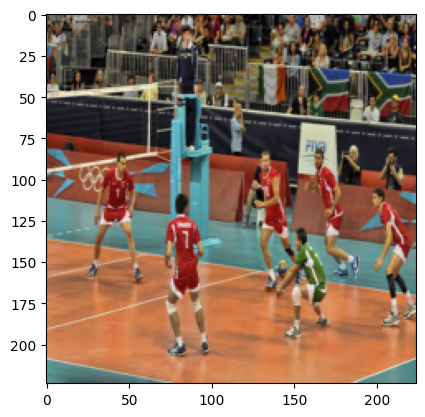

In [62]:
print(f"img_loss: {img_loss}")
print(f"text_loss: {text_loss}")
print(f"lm_loss: {lm_loss}")
show_img_tensor_CHW(batch_img_tensor[9].cpu())

In [63]:
img_contrastive_prob[0]

tensor([-2.9543, -2.7810, -2.7269, -2.8549, -2.7650, -2.9675, -3.1411, -2.7909,
        -2.9008, -2.9125, -3.5894, -2.9603, -2.8513, -2.9529, -2.8256, -3.7907,
        -3.0631, -2.9596, -2.8889, -4.6934], device='mps:0',
       grad_fn=<SelectBackward0>)

In [64]:
img_contrastive_prob[0].max()

tensor(-2.7269, device='mps:0', grad_fn=<MaxBackward1>)

In [65]:
label_mask = torch.arange(BATCH_SIZE, device=device)
img_pred = torch.argmax(img_contrastive_prob, dim=1)
img_accuracy = img_pred == label_mask
img_pred, img_accuracy.sum()

(tensor([ 2, 13, 13,  4, 19, 13, 17,  0, 13, 13,  1, 19,  1, 13,  0, 17, 19, 19,
         10, 19], device='mps:0'),
 tensor(2, device='mps:0'))

In [66]:
model_trained.text_transformer.text_token_embedding.text_encoder.decode(
    batch_target_tensor[-1]
)

'<bos>A person on a bicycle jumping over a dirt hill .<pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad><pad>'

In [67]:
def show(imgs, comments, labels):
    if not isinstance(imgs, list):
        imgs = [imgs]
    imgs_per_row = 1
    fix, axs = plt.subplots(
        nrows=(len(imgs) + imgs_per_row - 1) // imgs_per_row,
        ncols=imgs_per_row,
        squeeze=False,
        figsize=(16, 60),
    )
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VF.to_pil_image(img)
        row = i // imgs_per_row
        col = i % imgs_per_row
        axs[row, col].imshow(np.asarray(img))
        axs[row, col].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])
        title = f'pred: {comments[i].replace("<pad>", "").replace("<bos>", "")}\nlabel: {labels[i].replace("<pad>", "").replace("<bos>", "")}'
        axs[row, col].set_title(title)

Text(0.5, 1.0, 'Cosine similarity between text and image features')

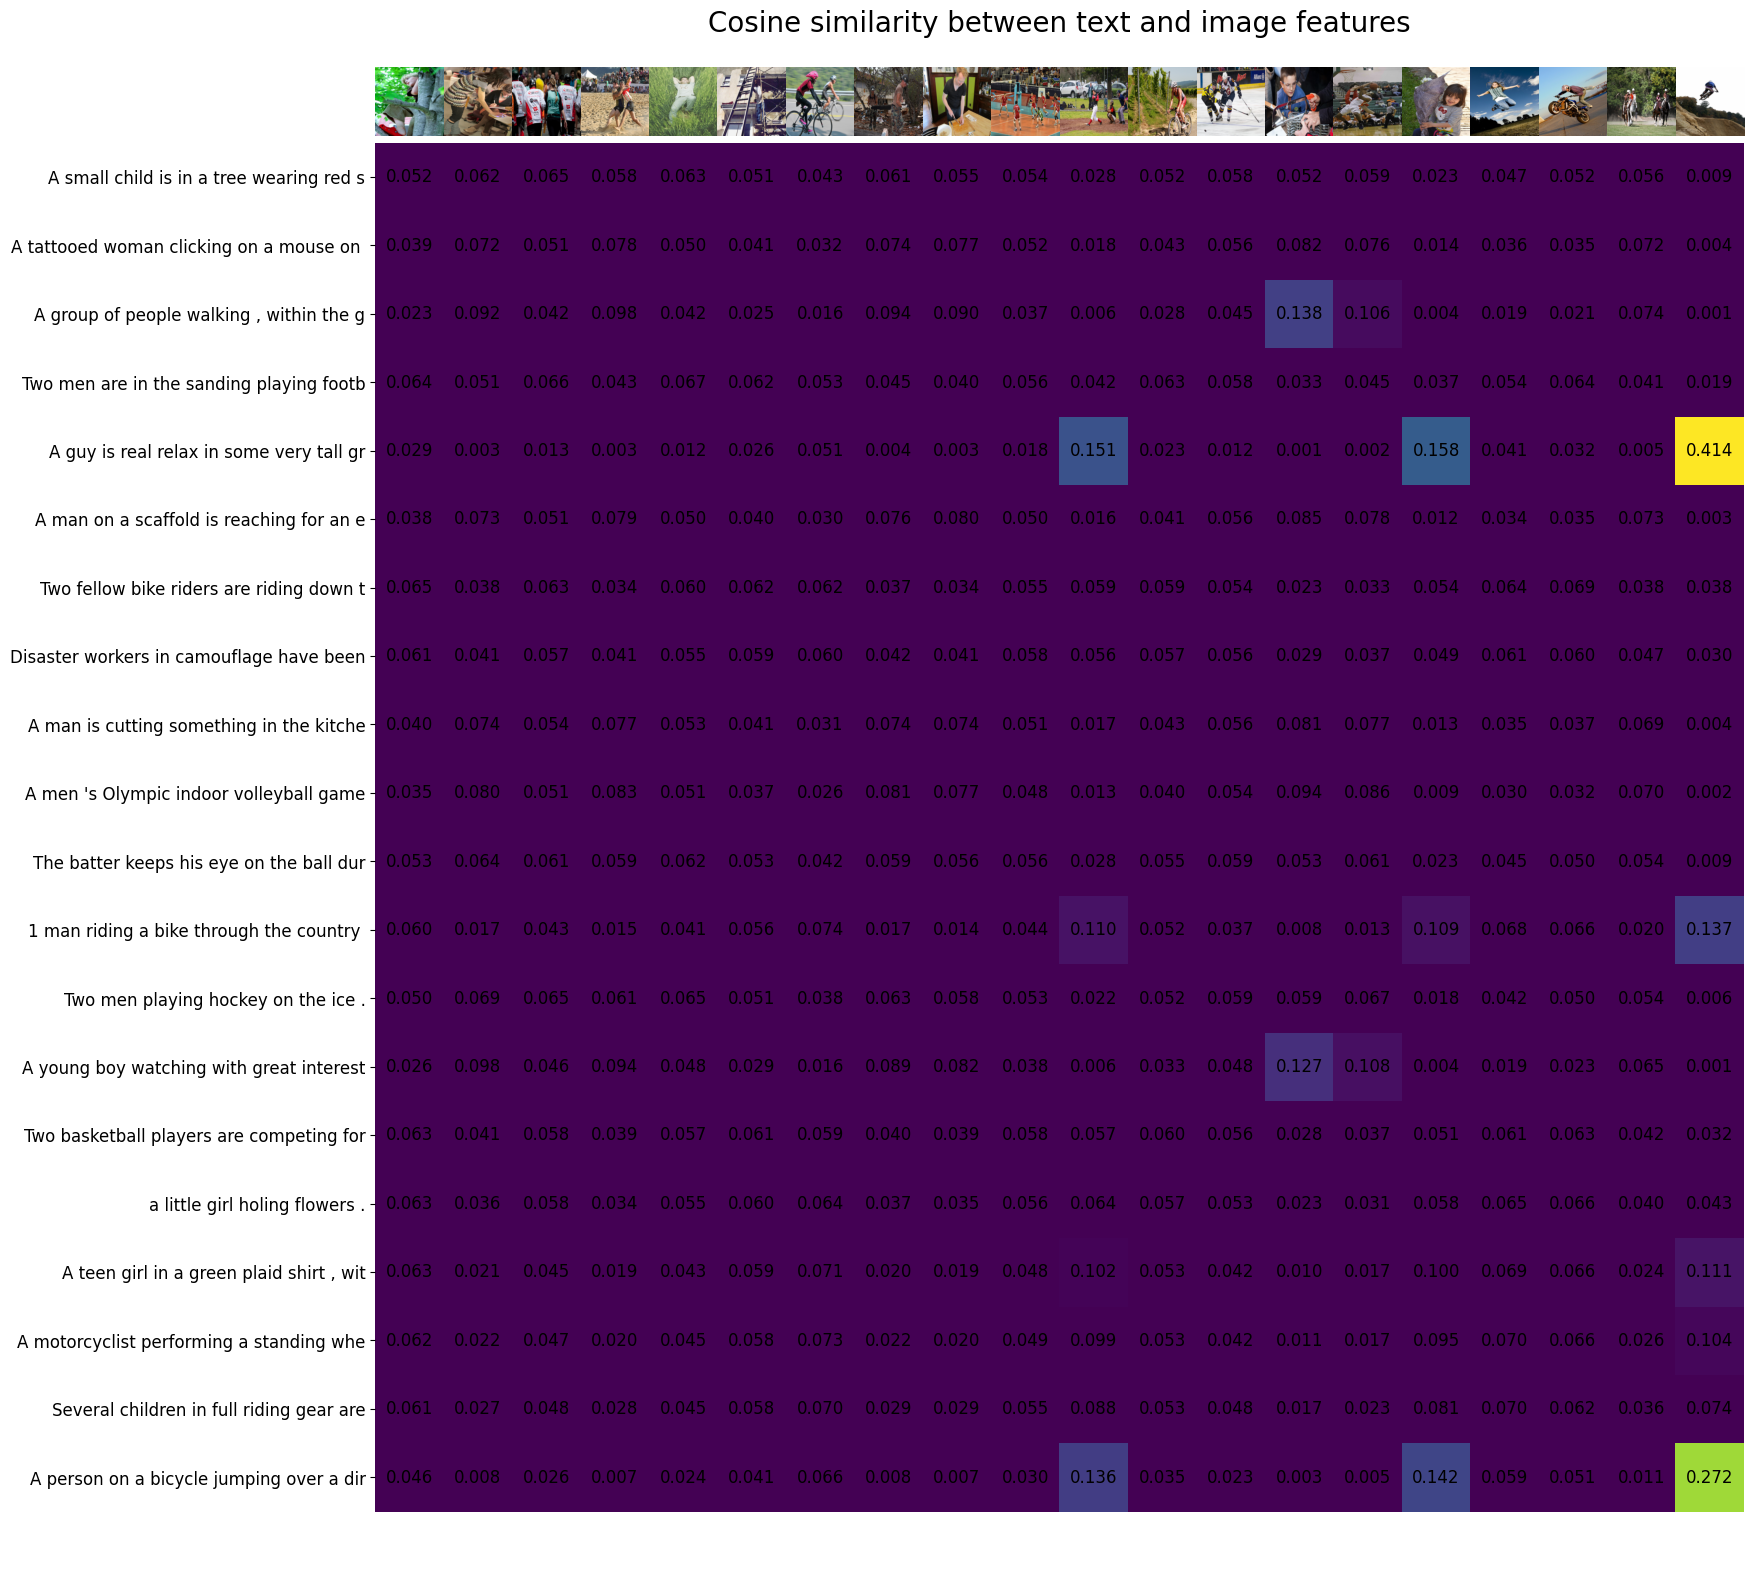

In [70]:
original_images = [VF.to_pil_image(img.detach()) for img in batch_img_tensor.cpu()]
labels = [
    model_trained.text_transformer.text_token_embedding.text_encoder.decode(
        target_tensor
    )
    .replace("<pad>", "")
    .replace("<bos>", "")[:40]
    for target_tensor in batch_target_tensor
]
count = len(original_images)
similarity = nn.Softmax(dim=-1)(img_contrastive_prob).cpu().detach()

plt.figure(figsize=(20, 20))
plt.imshow(similarity, vmin=0.1, vmax=0.3)
# plt.colorbar()
plt.yticks(range(count), labels, fontsize=12)
plt.xticks([])
for i, image in enumerate(original_images):
    plt.imshow(image, extent=(i - 0.5, i + 0.5, -1.6, -0.6), origin="lower")
for x in range(similarity.shape[1]):
    for y in range(similarity.shape[0]):
        plt.text(x, y, f"{similarity[y, x]:.3f}", ha="center", va="center", size=12)

for side in ["left", "top", "right", "bottom"]:
    plt.gca().spines[side].set_visible(False)

plt.xlim([-0.5, count - 0.5])
plt.ylim([count + 0.5, -2])

plt.title("Cosine similarity between text and image features", size=20)

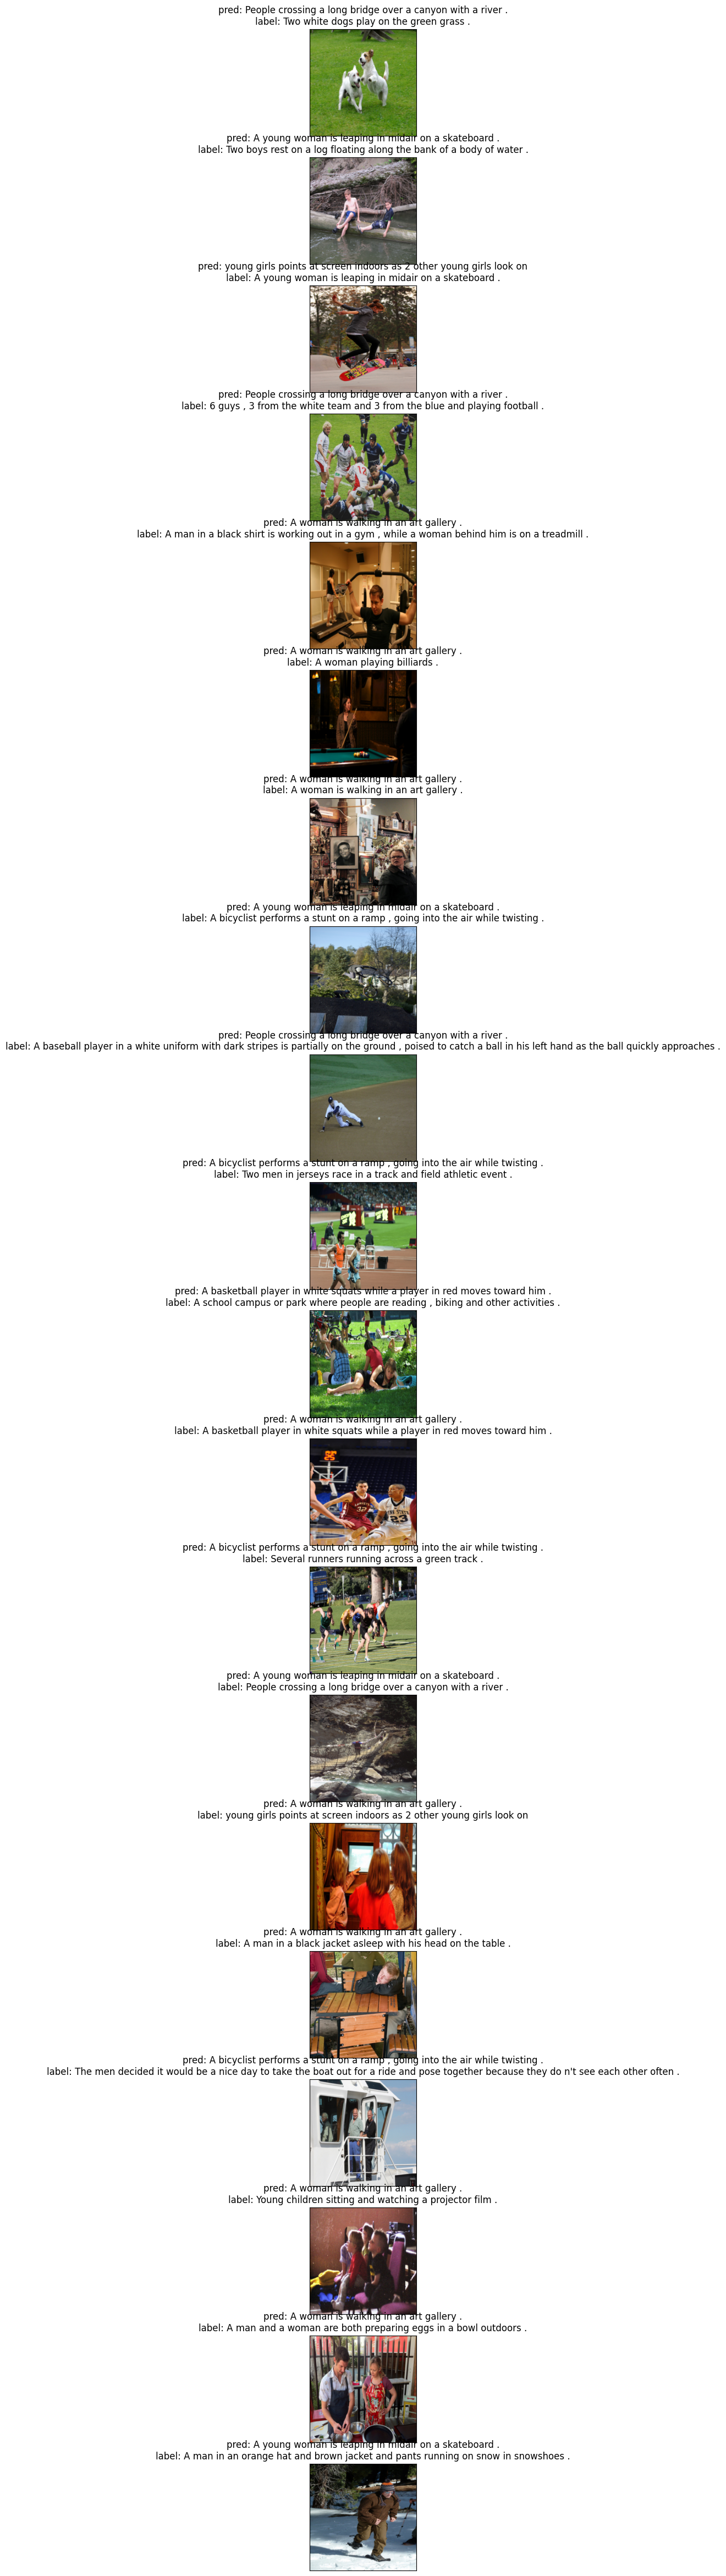

In [28]:
img_predicted_commments_index = torch.argmax(img_contrastive_prob, dim=1)

show(
    imgs=[img for img in batch_img_tensor.cpu()],
    labels=[
        model_trained.text_transformer.text_token_embedding.text_encoder.decode(
            target_tensor
        )
        for target_tensor in batch_target_tensor
    ],
    comments=[
        model_trained.text_transformer.text_token_embedding.text_encoder.decode(
            batch_target_tensor[predicted_comment_index]
        )
        for predicted_comment_index in img_predicted_commments_index
    ],
)

In [76]:
t = torch.arange(2 * 3 * 2).view(2, 3, -1)
print(t)
m = torch.arange(3)
print(m)
t[:, m, :]

tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]]])
tensor([0, 1, 2])


tensor([[[ 0,  1],
         [ 2,  3],
         [ 4,  5]],

        [[ 6,  7],
         [ 8,  9],
         [10, 11]]])